# GOAL

We want to see what the raw and gc normalized coverage looks like in all WGA samples.  This is as close to truth that we'll get for the sWGA samples.  We want to check:
- GCH1 gene in chromosome 12 exhibits a amplification in WGA samples
- no CNVs in chromosome 5
- coverage has spikes or dips across all samples because that will influence the normalization by removing top principal components.  If those spikes are dips are real (ie they exist in WGA samples), but we remove them via normalization, then we will get false positives/negatives.

We do not look at copy number calls here becauase the coverage plots are huge and we want to keep this report manageable.

In [1]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm
%matplotlib inline

In [2]:
PF_FIELD_WGA_COV_DIR = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv_wgs/output/pysamstats_gc"


In [3]:
def get_norm_gc(pysam_gc_stats_tsv):
    # Per-position GC content, read coverage.  
    # We don't care about properly paired reads here, since there could be 
    # inversions, deletions, insertions that alter orientation of read pairs.
    pysam_gc = pandas.read_csv(pysam_gc_stats_tsv, sep="\t")
        
    # Indicate the window start position
    pysam_gc["window"] =  300 * (pysam_gc.pos // 300)

    # Aggregate reads by window
    pysam_gc_win = pysam_gc.groupby(["chrom", "window"]).agg({'gc': {"gc_win_med": "median", 'gc_win_mean': "mean"},
                                              'reads_all': {"reads_all_win_med": "median", 
                                                            'reads_all_win_mean': "mean"}})
    pysam_gc_win.columns = pysam_gc_win.columns.droplevel()
    # Label each window with the ave gc_bin content
    pysam_gc_win["gc_bin"] =  pysam_gc_win["gc_win_mean"].apply(np.floor)

    # Find the mean reads in each GC Bin
    pysam_gc_per_pos_per_win = pysam_gc.reset_index().set_index(["chrom", "window"]).join(pysam_gc_win[["gc_bin"]])

    pysam_by_gc_bin = pysam_gc_per_pos_per_win.reset_index().groupby("gc_bin").agg({'reads_all': "mean"})
    pysam_by_gc_bin = pysam_by_gc_bin.rename(columns={'reads_all': 'reads_all_gc_bin_mean'})

    pysam_per_win_per_gc_bin = pysam_gc_win.reset_index().set_index("gc_bin").join(pysam_by_gc_bin, rsuffix="_median")
    pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.reset_index()
    pysam_per_win_per_gc_bin["window"] = pysam_per_win_per_gc_bin["window"].astype(float)
    pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.sort_values("window")

    pysam_per_win_per_gc_bin["norm_reads_all"] = pysam_per_win_per_gc_bin["reads_all_win_mean"] / pysam_per_win_per_gc_bin["reads_all_gc_bin_mean"]


    return pysam_per_win_per_gc_bin

In [4]:
def get_many_norm_gc(pysam_gc_stats_dir, chroms):
    """
    Gets per-window coverage for many samples.  
    Each sample should have a separate pysamstats_gc tsv in the same directory.
    """
    sample_stats_list = []
    for chrom in chroms:
        for i, pysam_gc_stats_tsv in enumerate(glob.glob(
                pysam_gc_stats_dir + os.sep + "*." + chrom + ".pysamstats_gc.txt")):
    #         display(pysam_gc_stats_tsv)
            pysamstat = get_norm_gc(pysam_gc_stats_tsv = pysam_gc_stats_tsv)
            sample, library, lane = os.path.basename(pysam_gc_stats_tsv).split(".")[:3]
            pysamstat["sample"] = sample
            pysamstat["library"] = library
            pysamstat["lane"] = lane
    #         display(pysamstat.shape)
    #         display(pysamstat.head())
    #         display(pysamstat.describe())

    #         if i > 2:
    #             break;

            sample_stats_list.append(pysamstat)
    
    all_samples_metrics = pandas.concat(sample_stats_list)
    return all_samples_metrics
    
        

In [5]:
pysamstats_per_win = get_many_norm_gc(PF_FIELD_WGA_COV_DIR, chroms=["Pf3D7_05_v3", "Pf3D7_12_v3"])
pysamstats_per_win = pysamstats_per_win[(pysamstats_per_win["gc_bin"] > 20 )& (pysamstats_per_win["gc_bin"] < 80) ]
display(pysamstats_per_win.shape)
display(pysamstats_per_win.head())
display(pysamstats_per_win.describe())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(183263, 12)

,gc_bin,chrom,window,reads_all_win_med,reads_all_win_mean,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all,sample,library,lane
4471,47.0,Pf3D7_05_v3,0.0,3.0,5.522727,47.000000,47.0,5.522727,1.000000,3909STDY6204221,15108303,18091_2#1
4448,39.0,Pf3D7_05_v3,300.0,16.0,14.276151,39.422594,41.0,51.575772,0.276800,3909STDY6204221,15108303,18091_2#1
4098,28.0,Pf3D7_05_v3,600.0,18.0,20.227425,28.237458,28.0,46.513048,0.434876,3909STDY6204221,15108303,18091_2#1
3898,26.0,Pf3D7_05_v3,900.0,25.0,23.023333,26.716667,26.0,46.310685,0.497149,3909STDY6204221,15108303,18091_2#1
4282,31.0,Pf3D7_05_v3,1200.0,17.0,20.536667,31.523333,32.0,37.492400,0.547755,3909STDY6204221,15108303,18091_2#1


,gc_bin,window,reads_all_win_med,reads_all_win_mean,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
count,183263.000000,1.832630e+05,183263.000000,183263.000000,183263.000000,183263.000000,183263.000000,183263.000000
mean,25.258961,9.442744e+05,166.332317,165.965636,25.739391,25.818384,167.805874,0.986856
std,4.420311,6.273438e+05,81.639162,81.334998,4.421359,4.505800,57.498060,0.364485
min,21.000000,0.000000e+00,1.000000,1.000000,21.000000,19.000000,1.000000,0.002653
25%,22.000000,4.056000e+05,105.000000,104.586667,22.486667,23.000000,134.910975,0.853887
50%,24.000000,8.787000e+05,180.000000,178.223333,24.423333,25.000000,175.428973,1.049051
75%,27.000000,1.368600e+06,216.000000,215.393333,27.633333,28.000000,199.391858,1.159480
max,59.000000,2.271300e+06,1880.000000,1600.453333,59.257143,59.000000,400.453333,11.121424


Total WGA Field Isolate Samples:

In [6]:
display(len(pysamstats_per_win["sample"].unique()))

43

# Raw Coverage for all WGA Samples Chr5

In [7]:
def plotter(total_cols, samples, sample_col, 
            df, y_label, x_label, x_col, y_col, sharey=False):
    total_samples = len(samples)
    total_rows =  int(np.ceil(total_samples // total_cols))
    fig, axes = plt.subplots(total_rows, total_cols, sharex='col', sharey=sharey, figsize=(15, 40))
    for row_idx, row in enumerate(axes):  
        for col_idx, ax in enumerate(row):
            sample_idx = (row_idx* total_cols) + col_idx
            if sample_idx >= len(samples):
                break  # No more plots, end of samples
            subset = df[(df[sample_col] == samples[sample_idx]) ].sort_values(x_col, ascending=True)
            ax.plot(subset[x_col], subset[y_col], color="orange")

            ax.set_title(samples[sample_idx])
            ax.set_ylabel(y_label)
            ax.set_xlabel(x_label)
    plt.tight_layout()
    plt.show()

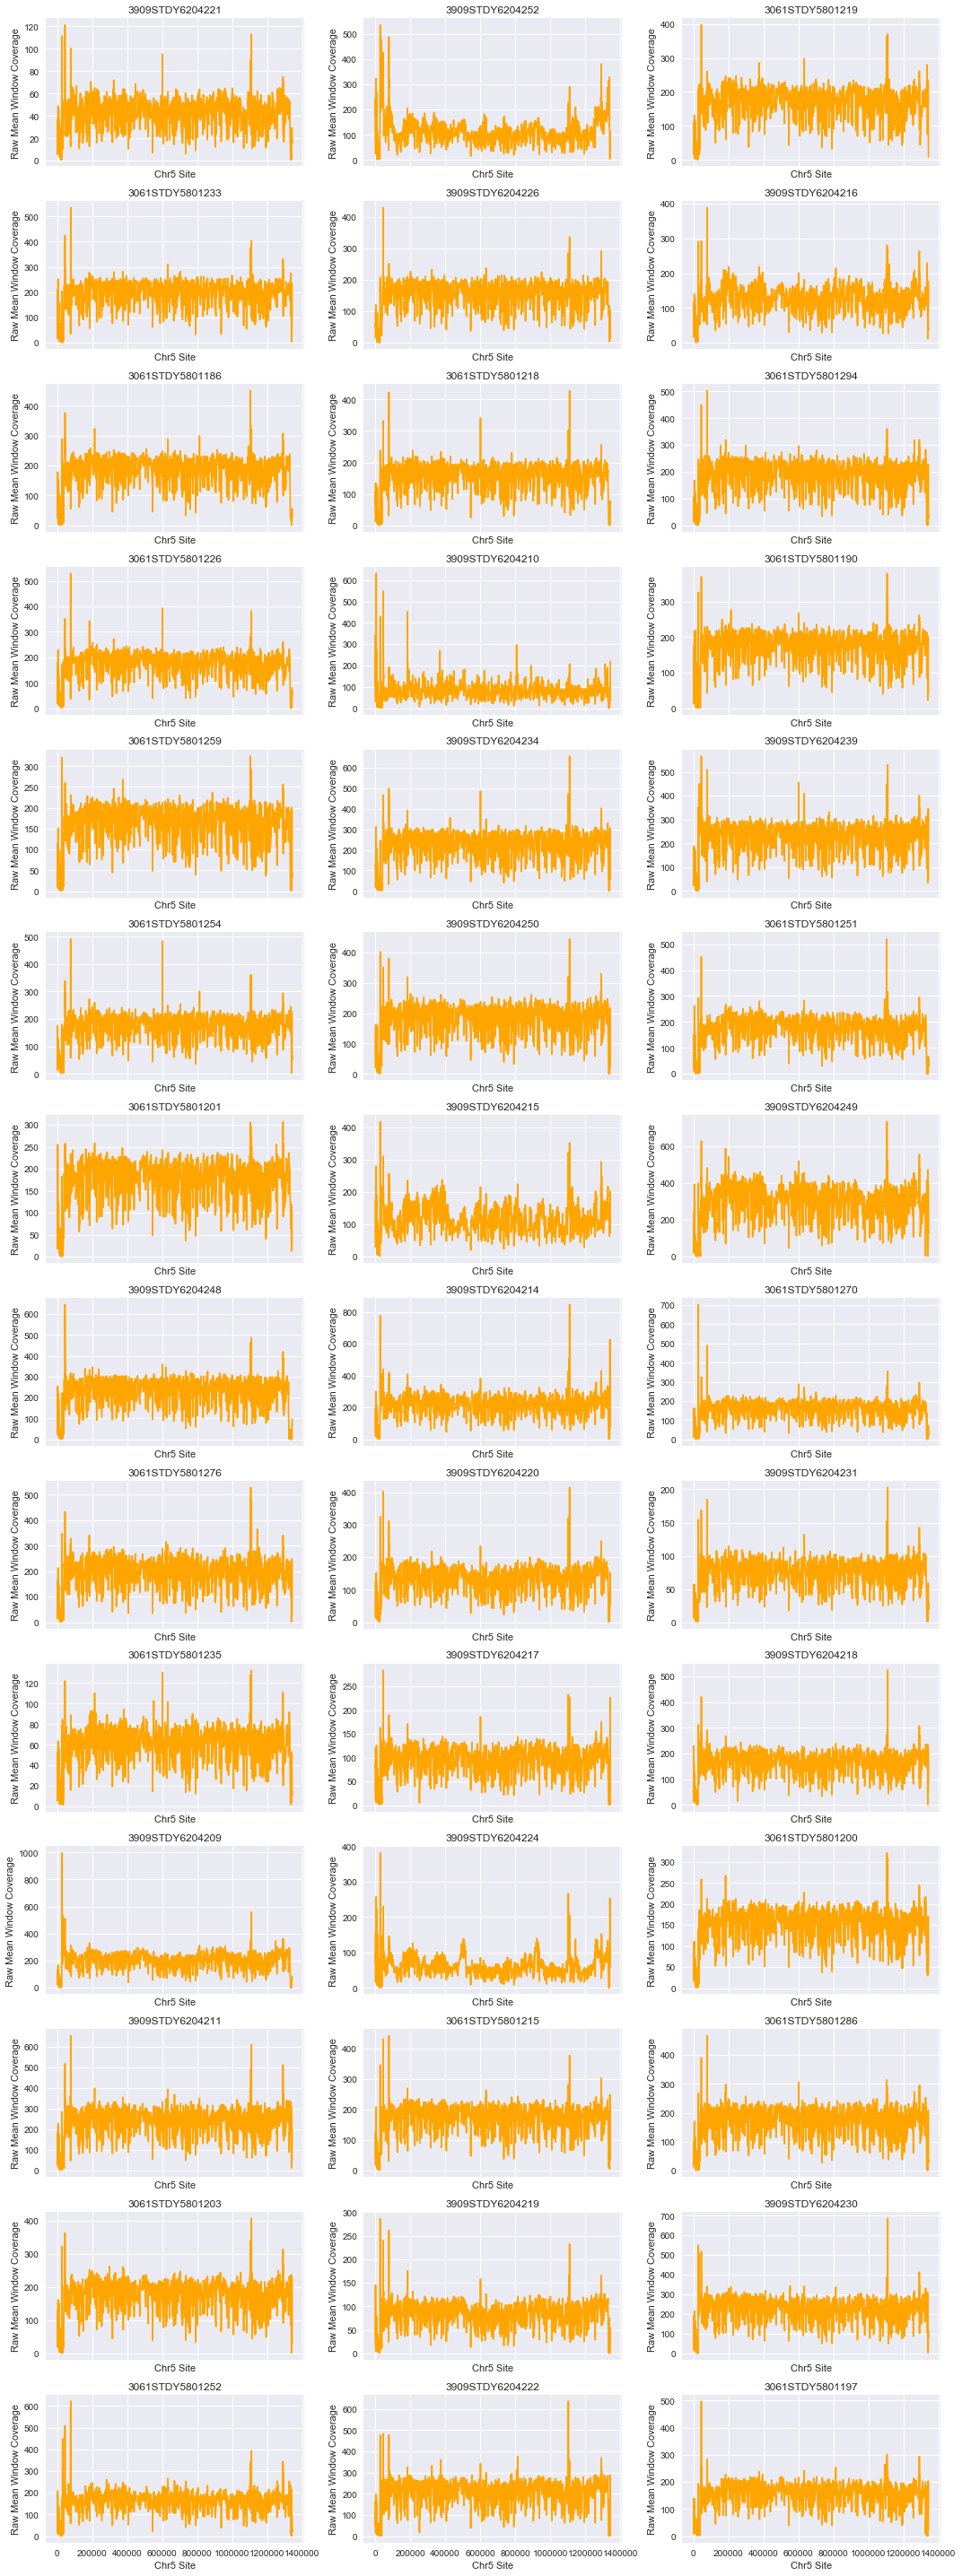

In [8]:
# Plot Raw Coverage along Chromosome 5
samples = pysamstats_per_win["sample"].unique()
plotter(total_cols=3, samples=samples, sample_col="sample", 
        df=pysamstats_per_win[pysamstats_per_win["chrom"] == "Pf3D7_05_v3"], 
        y_label="Raw Mean Window Coverage", x_label="Chr5 Site", 
        x_col="window", y_col="reads_all_win_mean", sharey=False)


# Normalized Coverage for all WGA Samples Chr5

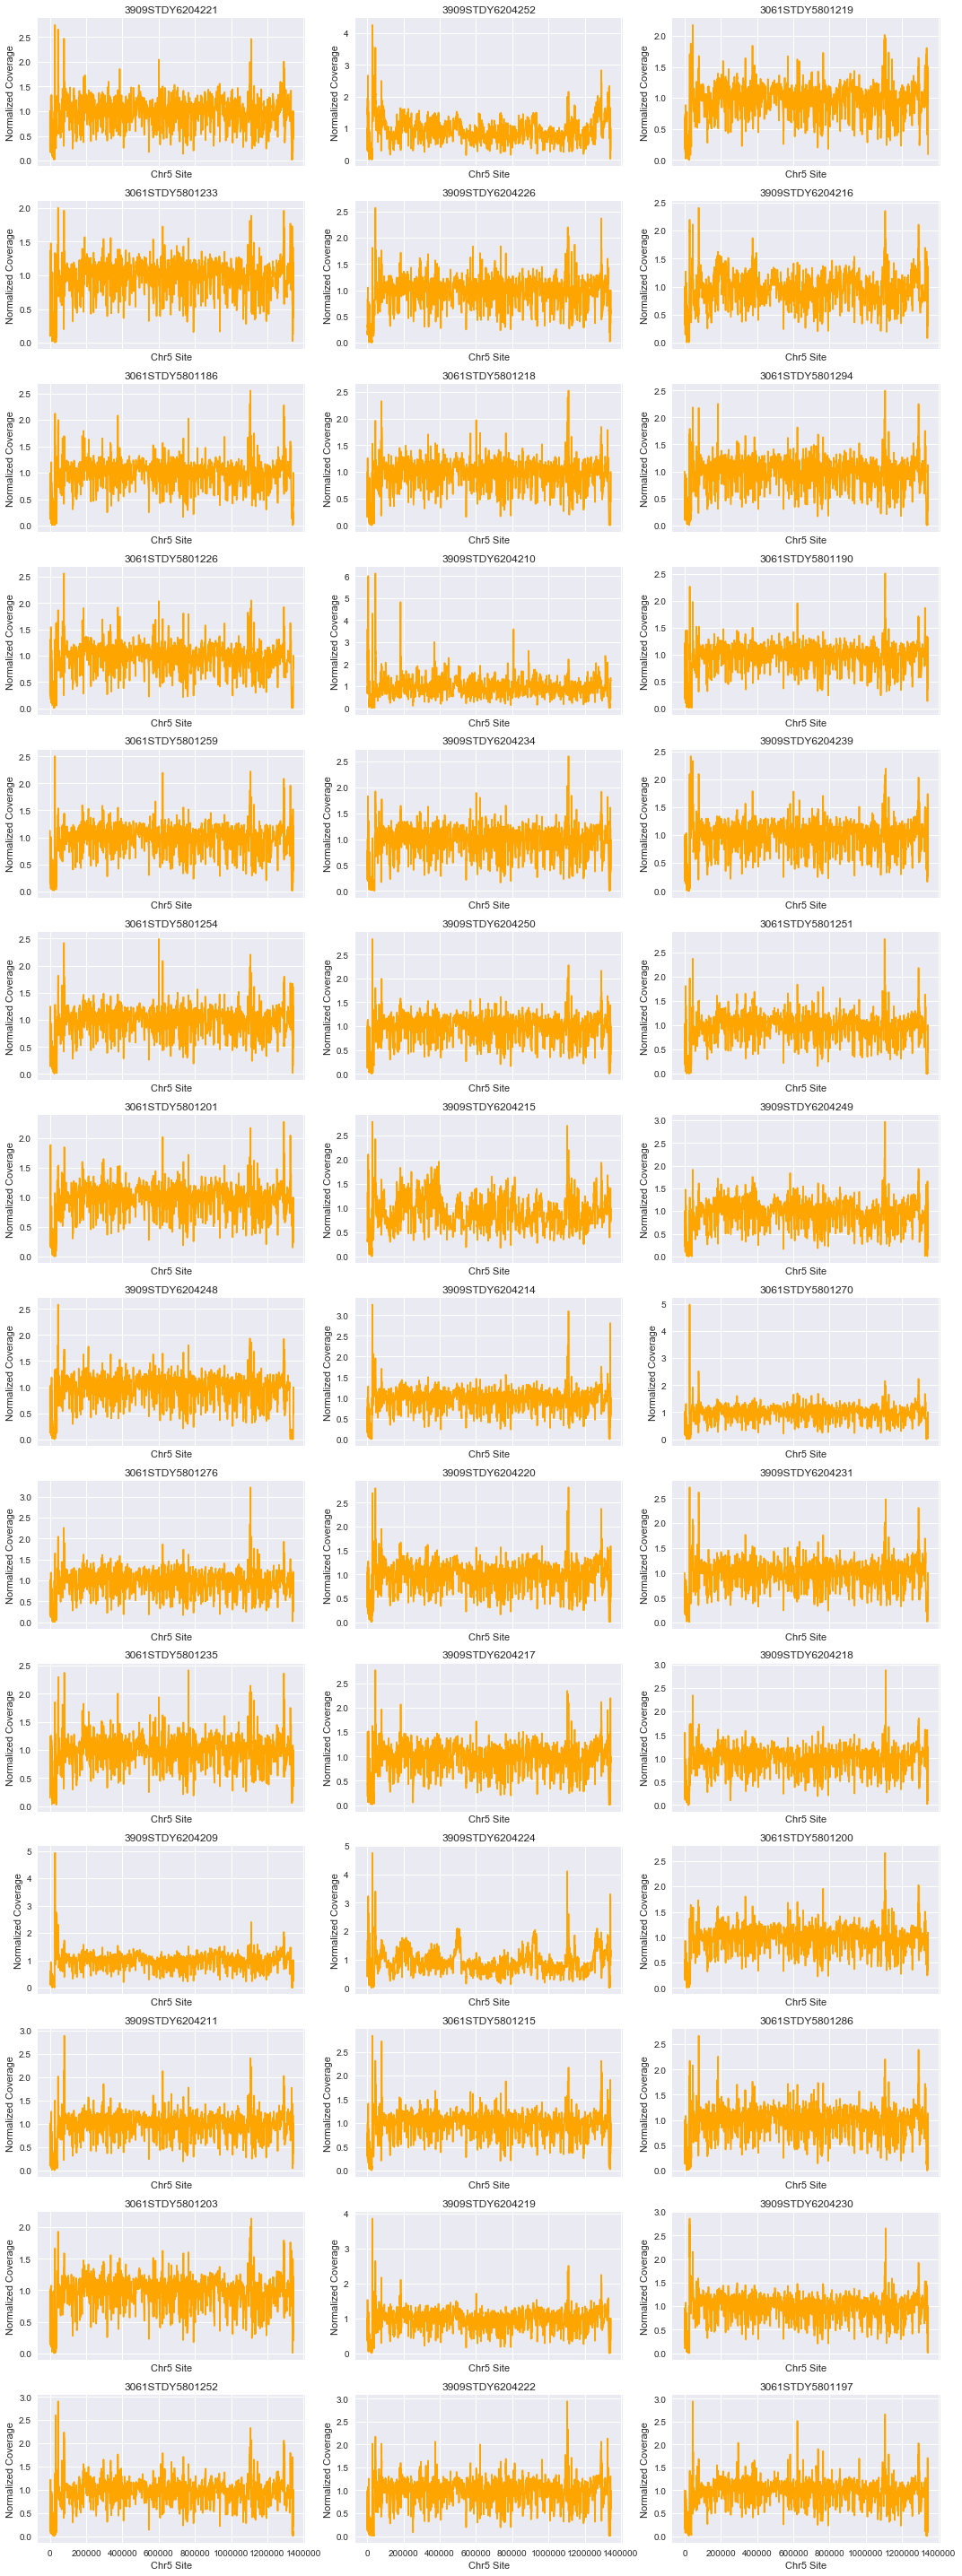

In [9]:
# Plot Normalized Coverage along Chr5
plotter(total_cols=3, samples=samples, sample_col="sample", 
        df=pysamstats_per_win[pysamstats_per_win["chrom"] == "Pf3D7_05_v3"], 
        y_label="Normalized Coverage", x_label="Chr5 Site", 
        x_col="window", y_col="norm_reads_all", sharey=False)

# Raw Coverage for all WGA Samples Chr12

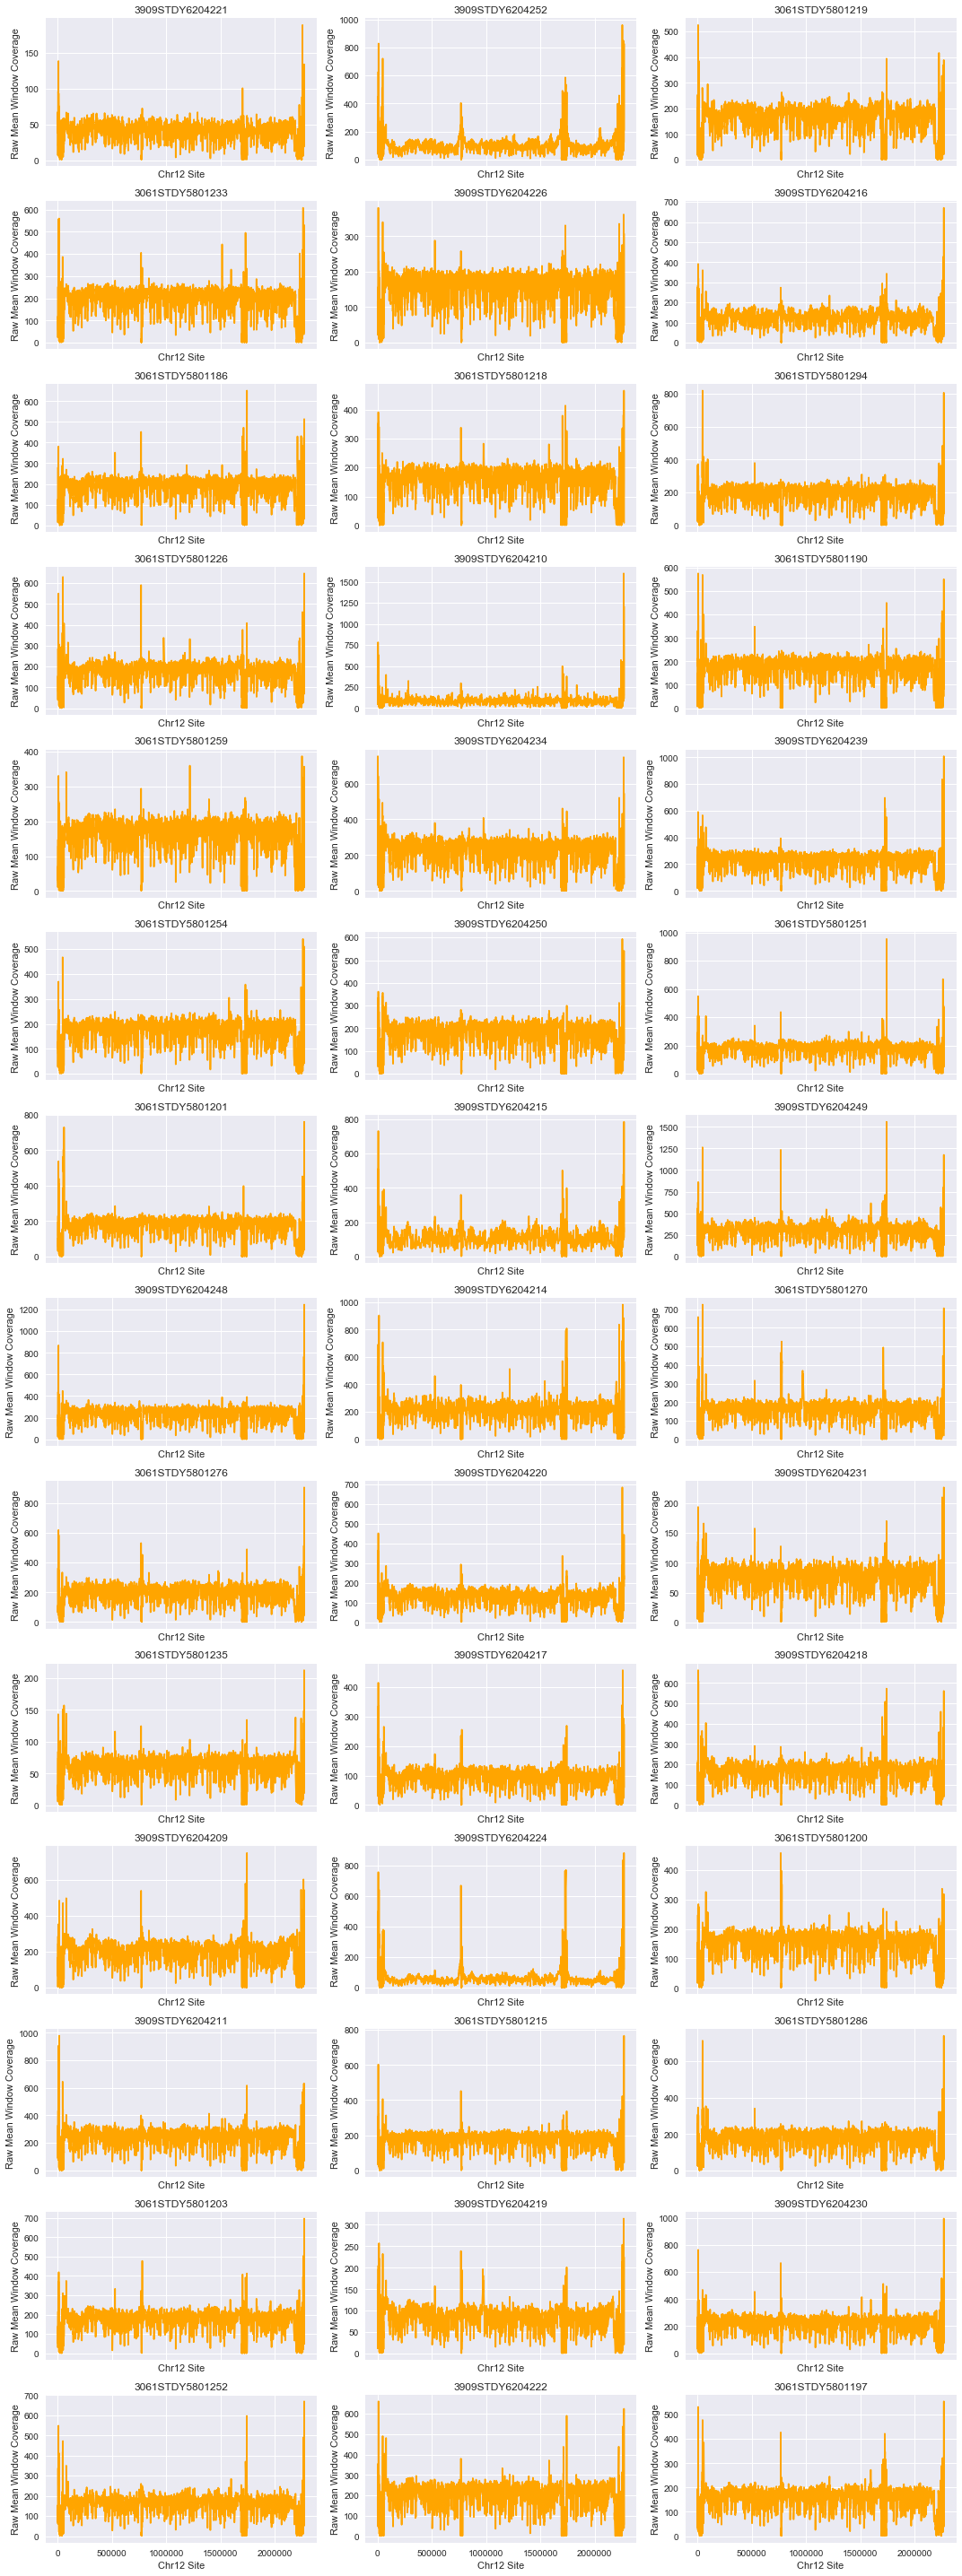

In [10]:
# Plot Raw Coverage along Chromosome 12
plotter(total_cols=3, samples=samples, sample_col="sample", 
        df=pysamstats_per_win[pysamstats_per_win["chrom"] == "Pf3D7_12_v3"], 
        y_label="Raw Mean Window Coverage", x_label="Chr12 Site", 
        x_col="window", y_col="reads_all_win_mean", sharey=False)


# Normalized Coverage for all WGA Samples Chr12

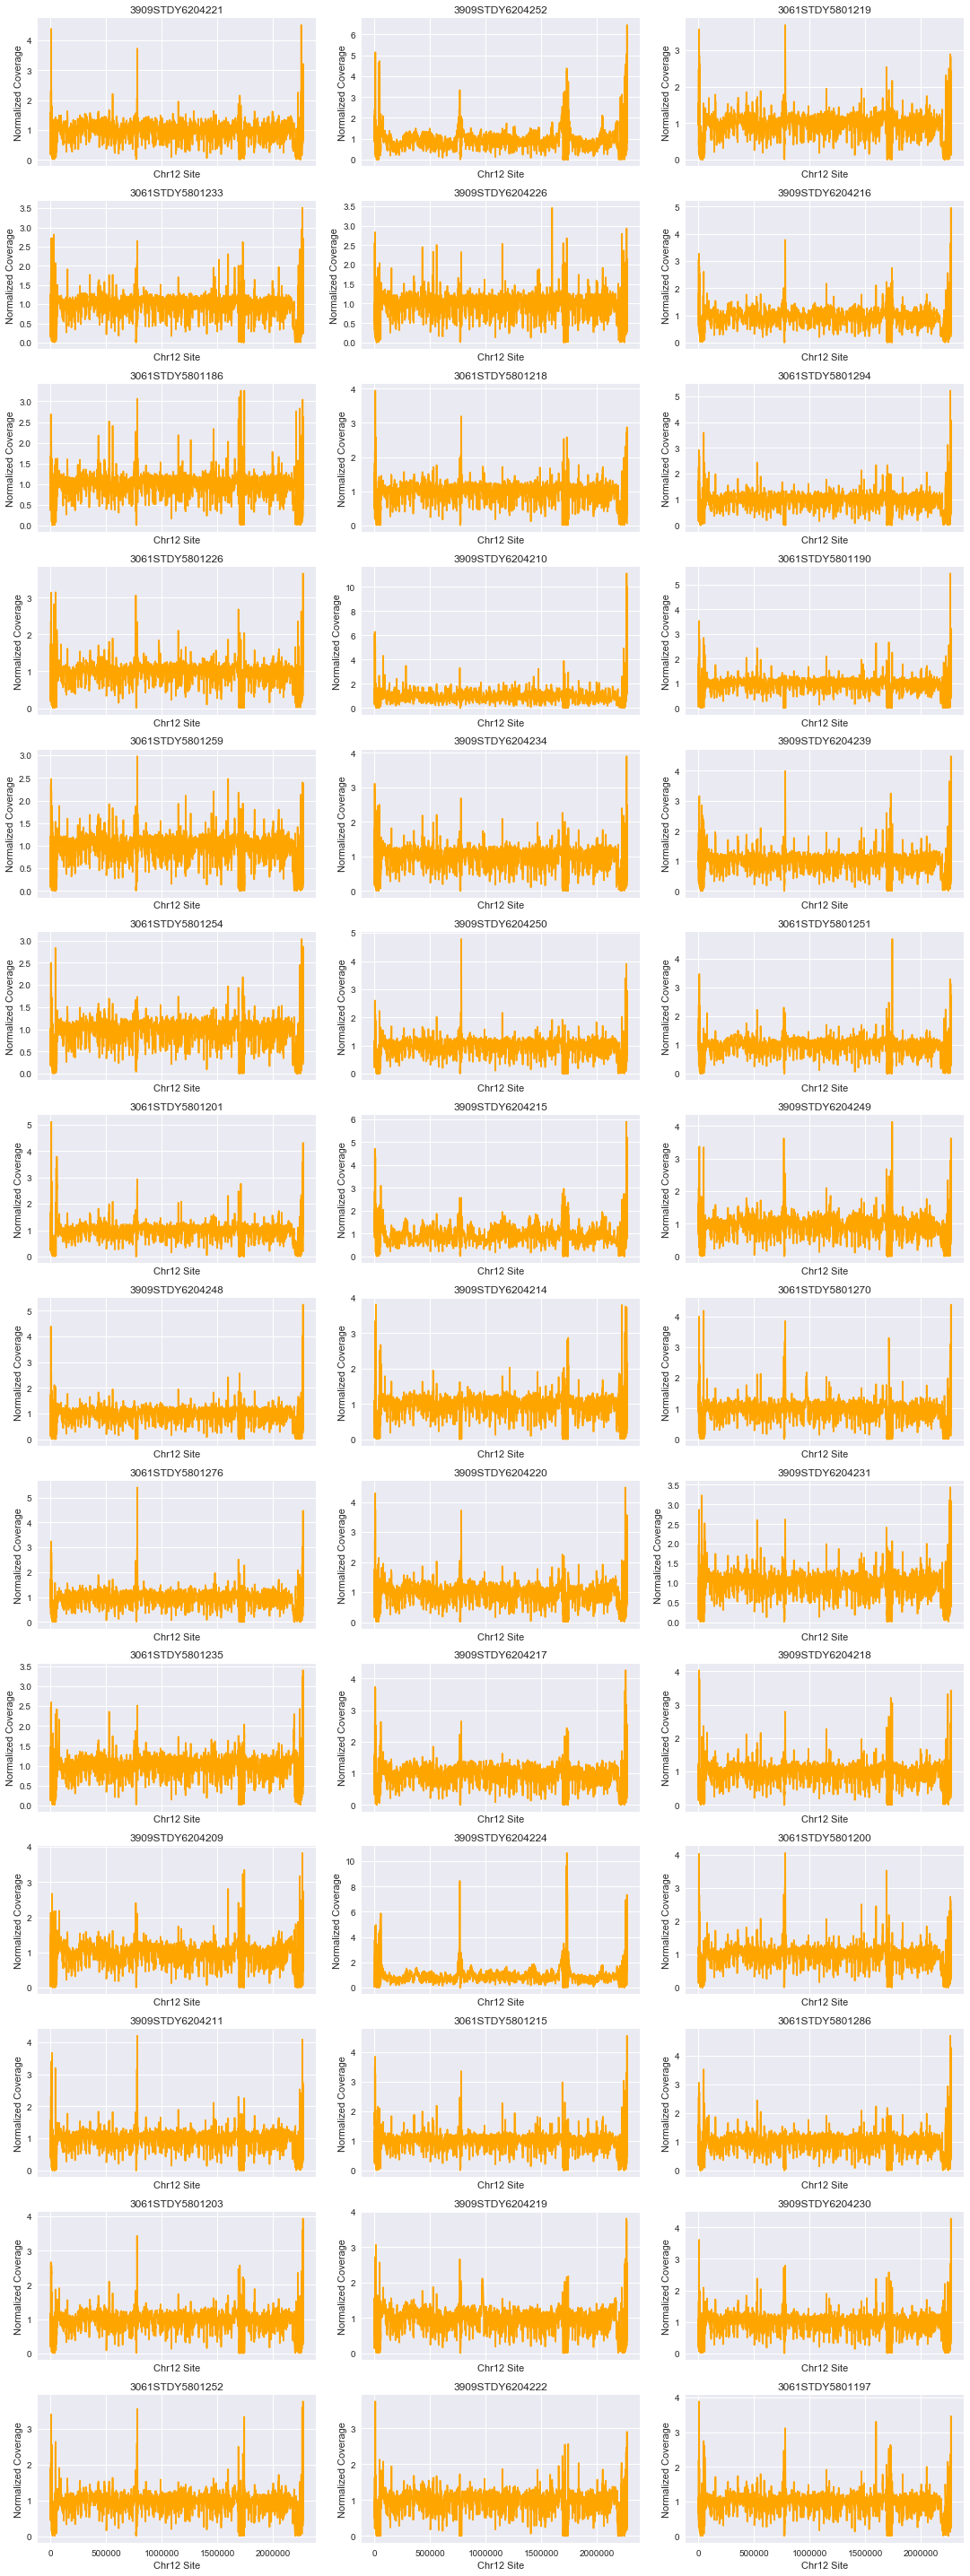

In [11]:
# Plot Normalized Coverage along Chr12
plotter(total_cols=3, samples=samples, sample_col="sample", 
        df=pysamstats_per_win[pysamstats_per_win["chrom"] == "Pf3D7_12_v3"], 
        y_label="Normalized Coverage", x_label="Chr12 Site", 
        x_col="window", y_col="norm_reads_all", sharey=False)